In [1]:
from google.colab import drive
import zipfile,os
from sklearn.metrics import f1_score,accuracy_score,precision_score, recall_score, jaccard_score
from sklearn.model_selection import train_test_split

In [2]:
drive.mount('/content/drive')
drive_path = "/content/drive/MyDrive/Dental-Segementation-and-Enumeration/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install timm
!pip install yacs

In [4]:
import os
import yaml
from yacs.config import CfgNode as CN

_C = CN()

# Base config files
_C.BASE = ['']

# -----------------------------------------------------------------------------
# Data settings
# -----------------------------------------------------------------------------
_C.DATA = CN()
# Batch size for a single GPU, could be overwritten by command line argument
_C.DATA.BATCH_SIZE = 128
# Path to dataset, could be overwritten by command line argument
_C.DATA.DATA_PATH = ''
# Dataset name
_C.DATA.DATASET = 'imagenet'
# Input image size
_C.DATA.IMG_SIZE = 224
# Interpolation to resize image (random, bilinear, bicubic)
_C.DATA.INTERPOLATION = 'bicubic'
# Use zipped dataset instead of folder dataset
# could be overwritten by command line argument
_C.DATA.ZIP_MODE = False
# Cache Data in Memory, could be overwritten by command line argument
_C.DATA.CACHE_MODE = 'part'
# Pin CPU memory in DataLoader for more efficient (sometimes) transfer to GPU.
_C.DATA.PIN_MEMORY = True
# Number of data loading threads
_C.DATA.NUM_WORKERS = 8

# -----------------------------------------------------------------------------
# Model settings
# -----------------------------------------------------------------------------
_C.MODEL = CN()
# Model type
_C.MODEL.TYPE = 'swin'
# Model name
_C.MODEL.NAME = 'swin_tiny_patch4_window7_224'
# Checkpoint to resume, could be overwritten by command line argument
_C.MODEL.PRETRAIN_CKPT = '/content/drive/MyDrive/Dental-Segementation-and-Enumeration/models/swin_tiny_patch4_window7_224.pth'
_C.MODEL.RESUME = ''
# Number of classes, overwritten in data preparation
_C.MODEL.NUM_CLASSES = 1000
# Dropout rate
_C.MODEL.DROP_RATE = 0.0
# Drop path rate
_C.MODEL.DROP_PATH_RATE = 0.1
# Label Smoothing
_C.MODEL.LABEL_SMOOTHING = 0.1

# Swin Transformer parameters
_C.MODEL.SWIN = CN()
_C.MODEL.SWIN.PATCH_SIZE = 4
_C.MODEL.SWIN.IN_CHANS = 3
_C.MODEL.SWIN.EMBED_DIM = 96
_C.MODEL.SWIN.DEPTHS = [2, 2, 6, 2]
_C.MODEL.SWIN.DECODER_DEPTHS = [2, 2, 6, 2]
_C.MODEL.SWIN.NUM_HEADS = [3, 6, 12, 24]
_C.MODEL.SWIN.WINDOW_SIZE = 7
_C.MODEL.SWIN.MLP_RATIO = 4.
_C.MODEL.SWIN.QKV_BIAS = True
_C.MODEL.SWIN.QK_SCALE = None
_C.MODEL.SWIN.APE = False
_C.MODEL.SWIN.PATCH_NORM = True
_C.MODEL.SWIN.FINAL_UPSAMPLE= "expand_first"

# -----------------------------------------------------------------------------
# Training settings
# -----------------------------------------------------------------------------
_C.TRAIN = CN()
_C.TRAIN.START_EPOCH = 0
_C.TRAIN.EPOCHS = 300
_C.TRAIN.WARMUP_EPOCHS = 20
_C.TRAIN.WEIGHT_DECAY = 0.05
_C.TRAIN.BASE_LR = 5e-4
_C.TRAIN.WARMUP_LR = 5e-7
_C.TRAIN.MIN_LR = 5e-6
# Clip gradient norm
_C.TRAIN.CLIP_GRAD = 5.0
# Auto resume from latest checkpoint
_C.TRAIN.AUTO_RESUME = True
# Gradient accumulation steps
# could be overwritten by command line argument
_C.TRAIN.ACCUMULATION_STEPS = 0
# Whether to use gradient checkpointing to save memory
# could be overwritten by command line argument
_C.TRAIN.USE_CHECKPOINT = False

# LR scheduler
_C.TRAIN.LR_SCHEDULER = CN()
_C.TRAIN.LR_SCHEDULER.NAME = 'cosine'
# Epoch interval to decay LR, used in StepLRScheduler
_C.TRAIN.LR_SCHEDULER.DECAY_EPOCHS = 30
# LR decay rate, used in StepLRScheduler
_C.TRAIN.LR_SCHEDULER.DECAY_RATE = 0.1

# Optimizer
_C.TRAIN.OPTIMIZER = CN()
_C.TRAIN.OPTIMIZER.NAME = 'adamw'
# Optimizer Epsilon
_C.TRAIN.OPTIMIZER.EPS = 1e-8
# Optimizer Betas
_C.TRAIN.OPTIMIZER.BETAS = (0.9, 0.999)
# SGD momentum
_C.TRAIN.OPTIMIZER.MOMENTUM = 0.9

# -----------------------------------------------------------------------------
# Augmentation settings
# -----------------------------------------------------------------------------
_C.AUG = CN()
# Color jitter factor
_C.AUG.COLOR_JITTER = 0.4
# Use AutoAugment policy. "v0" or "original"
_C.AUG.AUTO_AUGMENT = 'rand-m9-mstd0.5-inc1'
# Random erase prob
_C.AUG.REPROB = 0.25
# Random erase mode
_C.AUG.REMODE = 'pixel'
# Random erase count
_C.AUG.RECOUNT = 1
# Mixup alpha, mixup enabled if > 0
_C.AUG.MIXUP = 0.8
# Cutmix alpha, cutmix enabled if > 0
_C.AUG.CUTMIX = 1.0
# Cutmix min/max ratio, overrides alpha and enables cutmix if set
_C.AUG.CUTMIX_MINMAX = None
# Probability of performing mixup or cutmix when either/both is enabled
_C.AUG.MIXUP_PROB = 1.0
# Probability of switching to cutmix when both mixup and cutmix enabled
_C.AUG.MIXUP_SWITCH_PROB = 0.5
# How to apply mixup/cutmix params. Per "batch", "pair", or "elem"
_C.AUG.MIXUP_MODE = 'batch'

# -----------------------------------------------------------------------------
# Testing settings
# -----------------------------------------------------------------------------
_C.TEST = CN()
# Whether to use center crop when testing
_C.TEST.CROP = True

# -----------------------------------------------------------------------------
# Misc
# -----------------------------------------------------------------------------
# Mixed precision opt level, if O0, no amp is used ('O0', 'O1', 'O2')
# overwritten by command line argument
_C.AMP_OPT_LEVEL = ''
# Path to output folder, overwritten by command line argument
_C.OUTPUT = ''
# Tag of experiment, overwritten by command line argument
_C.TAG = 'default'
# Frequency to save checkpoint
_C.SAVE_FREQ = 10
# Frequency to logging info
_C.PRINT_FREQ = 10
# Fixed random seed
_C.SEED = 0
# Perform evaluation only, overwritten by command line argument
_C.EVAL_MODE = False
# Test throughput only, overwritten by command line argument
_C.THROUGHPUT_MODE = False
# local rank for DistributedDataParallel, given by command line argument
_C.LOCAL_RANK = 0


def _update_config_from_file(config, cfg_file):
    config.defrost()
    with open(cfg_file, 'r') as f:
        yaml_cfg = yaml.load(f, Loader=yaml.FullLoader)

    for cfg in yaml_cfg.setdefault('BASE', ['']):
        if cfg:
            _update_config_from_file(
                config, os.path.join(os.path.dirname(cfg_file), cfg)
            )
    print('=> merge config from {}'.format(cfg_file))
    config.merge_from_file(cfg_file)
    config.freeze()


def update_config(config, args):
    _update_config_from_file(config, args.cfg)

    config.defrost()
    if args.opts:
        config.merge_from_list(args.opts)

    # merge from specific arguments
    if args.batch_size:
        config.DATA.BATCH_SIZE = args.batch_size
    if args.zip:
        config.DATA.ZIP_MODE = True
    if args.cache_mode:
        config.DATA.CACHE_MODE = args.cache_mode
    if args.resume:
        config.MODEL.RESUME = args.resume
    if args.accumulation_steps:
        config.TRAIN.ACCUMULATION_STEPS = args.accumulation_steps
    if args.use_checkpoint:
        config.TRAIN.USE_CHECKPOINT = True
    if args.amp_opt_level:
        config.AMP_OPT_LEVEL = args.amp_opt_level
    if args.tag:
        config.TAG = args.tag
    if args.eval:
        config.EVAL_MODE = True
    if args.throughput:
        config.THROUGHPUT_MODE = True

    config.freeze()


def get_config(args):
    """Get a yacs CfgNode object with default values."""
    # Return a clone so that the defaults will not be altered
    # This is for the "local variable" use pattern
    config = _C.clone()
    update_config(config, args)

    return config

In [5]:
import torch
import torch.nn as nn
import torch.utils.checkpoint as checkpoint
from einops import rearrange
from timm.models.layers import DropPath, to_2tuple, trunc_normal_


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size

    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows


def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image

    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x


class WindowAttention(nn.Module):
    r""" Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.

    Args:
        dim (int): Number of input channels.
        window_size (tuple[int]): The height and width of the window.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
    """

    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):

        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        """
        Args:
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

    def extra_repr(self) -> str:
        return f'dim={self.dim}, window_size={self.window_size}, num_heads={self.num_heads}'

    def flops(self, N):
        # calculate flops for 1 window with token length of N
        flops = 0
        # qkv = self.qkv(x)
        flops += N * self.dim * 3 * self.dim
        # attn = (q @ k.transpose(-2, -1))
        flops += self.num_heads * N * (self.dim // self.num_heads) * N
        #  x = (attn @ v)
        flops += self.num_heads * N * N * (self.dim // self.num_heads)
        # x = self.proj(x)
        flops += N * self.dim * self.dim
        return flops


class SwinTransformerBlock(nn.Module):
    r""" Swin Transformer Block.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resulotion.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        if self.shift_size > 0:
            # calculate attention mask for SW-MSA
            H, W = self.input_resolution
            img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
            h_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1

            mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
            mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)

    def forward(self, x):
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C

        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x
        x = x.view(B, H * W, C)

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, num_heads={self.num_heads}, " \
               f"window_size={self.window_size}, shift_size={self.shift_size}, mlp_ratio={self.mlp_ratio}"

    def flops(self):
        flops = 0
        H, W = self.input_resolution
        # norm1
        flops += self.dim * H * W
        # W-MSA/SW-MSA
        nW = H * W / self.window_size / self.window_size
        flops += nW * self.attn.flops(self.window_size * self.window_size)
        # mlp
        flops += 2 * H * W * self.dim * self.dim * self.mlp_ratio
        # norm2
        flops += self.dim * H * W
        return flops


class PatchMerging(nn.Module):
    r""" Patch Merging Layer.

    Args:
        input_resolution (tuple[int]): Resolution of input feature.
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."

        x = x.view(B, H, W, C)

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        x = x.view(B, -1, 4 * C)  # B H/2*W/2 4*C

        x = self.norm(x)
        x = self.reduction(x)

        return x

    def extra_repr(self) -> str:
        return f"input_resolution={self.input_resolution}, dim={self.dim}"

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.dim
        flops += (H // 2) * (W // 2) * 4 * self.dim * 2 * self.dim
        return flops

class PatchExpand(nn.Module):
    def __init__(self, input_resolution, dim, dim_scale=2, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.expand = nn.Linear(dim, 2*dim, bias=False) if dim_scale==2 else nn.Identity()
        self.norm = norm_layer(dim // dim_scale)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        x = self.expand(x)
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        x = x.view(B, H, W, C)
        x = rearrange(x, 'b h w (p1 p2 c)-> b (h p1) (w p2) c', p1=2, p2=2, c=C//4)
        x = x.view(B,-1,C//4)
        x= self.norm(x)

        return x

class FinalPatchExpand_X4(nn.Module):
    def __init__(self, input_resolution, dim, dim_scale=4, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.dim_scale = dim_scale
        self.expand = nn.Linear(dim, 16*dim, bias=False)
        self.output_dim = dim
        self.norm = norm_layer(self.output_dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        x = self.expand(x)
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        x = x.view(B, H, W, C)
        x = rearrange(x, 'b h w (p1 p2 c)-> b (h p1) (w p2) c', p1=self.dim_scale, p2=self.dim_scale, c=C//(self.dim_scale**2))
        x = x.view(B,-1,self.output_dim)
        x= self.norm(x)

        return x

class BasicLayer(nn.Module):
    """ A basic Swin Transformer layer for one stage.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer)
            for i in range(depth)])

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def forward(self, x):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        if self.downsample is not None:
            x = self.downsample(x)
        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"

    def flops(self):
        flops = 0
        for blk in self.blocks:
            flops += blk.flops()
        if self.downsample is not None:
            flops += self.downsample.flops()
        return flops

class BasicLayer_up(nn.Module):
    """ A basic Swin Transformer layer for one stage.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        upsample (nn.Module | None, optional): upsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, upsample=None, use_checkpoint=False):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer)
            for i in range(depth)])

        # patch merging layer
        if upsample is not None:
            self.upsample = PatchExpand(input_resolution, dim=dim, dim_scale=2, norm_layer=norm_layer)
        else:
            self.upsample = None

    def forward(self, x):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        if self.upsample is not None:
            x = self.upsample(x)
        return x

class PatchEmbed(nn.Module):
    r""" Image to Patch Embedding

    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        B, C, H, W = x.shape
        # FIXME look at relaxing size constraints
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)  # B Ph*Pw C
        if self.norm is not None:
            x = self.norm(x)
        return x

    def flops(self):
        Ho, Wo = self.patches_resolution
        flops = Ho * Wo * self.embed_dim * self.in_chans * (self.patch_size[0] * self.patch_size[1])
        if self.norm is not None:
            flops += Ho * Wo * self.embed_dim
        return flops


class SwinTransformerSys(nn.Module):
    r""" Swin Transformer
        A PyTorch impl of : `Swin Transformer: Hierarchical Vision Transformer using Shifted Windows`  -
          https://arxiv.org/pdf/2103.14030

    Args:
        img_size (int | tuple(int)): Input image size. Default 224
        patch_size (int | tuple(int)): Patch size. Default: 4
        in_chans (int): Number of input image channels. Default: 3
        num_classes (int): Number of classes for classification head. Default: 1000
        embed_dim (int): Patch embedding dimension. Default: 96
        depths (tuple(int)): Depth of each Swin Transformer layer.
        num_heads (tuple(int)): Number of attention heads in different layers.
        window_size (int): Window size. Default: 7
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4
        qkv_bias (bool): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float): Override default qk scale of head_dim ** -0.5 if set. Default: None
        drop_rate (float): Dropout rate. Default: 0
        attn_drop_rate (float): Attention dropout rate. Default: 0
        drop_path_rate (float): Stochastic depth rate. Default: 0.1
        norm_layer (nn.Module): Normalization layer. Default: nn.LayerNorm.
        ape (bool): If True, add absolute position embedding to the patch embedding. Default: False
        patch_norm (bool): If True, add normalization after patch embedding. Default: True
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, num_classes=1000,
                 embed_dim=96, depths=[2, 2, 2, 2], depths_decoder=[1, 2, 2, 2], num_heads=[3, 6, 12, 24],
                 window_size=7, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
                 use_checkpoint=False, final_upsample="expand_first", **kwargs):
        super().__init__()

        print("SwinTransformerSys expand initial----depths:{};depths_decoder:{};drop_path_rate:{};num_classes:{}".format(depths,
        depths_decoder,drop_path_rate,num_classes))

        self.num_classes = num_classes
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))
        self.num_features_up = int(embed_dim * 2)
        self.mlp_ratio = mlp_ratio
        self.final_upsample = final_upsample

        # split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        # absolute position embedding
        if self.ape:
            self.absolute_pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
            trunc_normal_(self.absolute_pos_embed, std=.02)

        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule

        # build encoder and bottleneck layers
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = BasicLayer(dim=int(embed_dim * 2 ** i_layer),
                               input_resolution=(patches_resolution[0] // (2 ** i_layer),
                                                 patches_resolution[1] // (2 ** i_layer)),
                               depth=depths[i_layer],
                               num_heads=num_heads[i_layer],
                               window_size=window_size,
                               mlp_ratio=self.mlp_ratio,
                               qkv_bias=qkv_bias, qk_scale=qk_scale,
                               drop=drop_rate, attn_drop=attn_drop_rate,
                               drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],
                               norm_layer=norm_layer,
                               downsample=PatchMerging if (i_layer < self.num_layers - 1) else None,
                               use_checkpoint=use_checkpoint)
            self.layers.append(layer)

        # build decoder layers
        self.layers_up = nn.ModuleList()
        self.concat_back_dim = nn.ModuleList()
        for i_layer in range(self.num_layers):
            concat_linear = nn.Linear(2*int(embed_dim*2**(self.num_layers-1-i_layer)),
            int(embed_dim*2**(self.num_layers-1-i_layer))) if i_layer > 0 else nn.Identity()
            if i_layer ==0 :
                layer_up = PatchExpand(input_resolution=(patches_resolution[0] // (2 ** (self.num_layers-1-i_layer)),
                patches_resolution[1] // (2 ** (self.num_layers-1-i_layer))), dim=int(embed_dim * 2 ** (self.num_layers-1-i_layer)), dim_scale=2, norm_layer=norm_layer)
            else:
                layer_up = BasicLayer_up(dim=int(embed_dim * 2 ** (self.num_layers-1-i_layer)),
                                input_resolution=(patches_resolution[0] // (2 ** (self.num_layers-1-i_layer)),
                                                    patches_resolution[1] // (2 ** (self.num_layers-1-i_layer))),
                                depth=depths[(self.num_layers-1-i_layer)],
                                num_heads=num_heads[(self.num_layers-1-i_layer)],
                                window_size=window_size,
                                mlp_ratio=self.mlp_ratio,
                                qkv_bias=qkv_bias, qk_scale=qk_scale,
                                drop=drop_rate, attn_drop=attn_drop_rate,
                                drop_path=dpr[sum(depths[:(self.num_layers-1-i_layer)]):sum(depths[:(self.num_layers-1-i_layer) + 1])],
                                norm_layer=norm_layer,
                                upsample=PatchExpand if (i_layer < self.num_layers - 1) else None,
                                use_checkpoint=use_checkpoint)
            self.layers_up.append(layer_up)
            self.concat_back_dim.append(concat_linear)

        self.norm = norm_layer(self.num_features)
        self.norm_up= norm_layer(self.embed_dim)

        if self.final_upsample == "expand_first":
            print("---final upsample expand_first---")
            self.up = FinalPatchExpand_X4(input_resolution=(img_size//patch_size,img_size//patch_size),dim_scale=4,dim=embed_dim)
            self.output = nn.Conv2d(in_channels=embed_dim,out_channels=self.num_classes,kernel_size=1,bias=False)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'absolute_pos_embed'}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {'relative_position_bias_table'}

    #Encoder and Bottleneck
    def forward_features(self, x):
        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)
        x_downsample = []

        for layer in self.layers:
            x_downsample.append(x)
            x = layer(x)

        x = self.norm(x)  # B L C

        return x, x_downsample

    #Dencoder and Skip connection
    def forward_up_features(self, x, x_downsample):
        for inx, layer_up in enumerate(self.layers_up):
            if inx == 0:
                x = layer_up(x)
            else:
                x = torch.cat([x,x_downsample[3-inx]],-1)
                x = self.concat_back_dim[inx](x)
                x = layer_up(x)

        x = self.norm_up(x)  # B L C

        return x

    def up_x4(self, x):
        H, W = self.patches_resolution
        B, L, C = x.shape
        assert L == H*W, "input features has wrong size"

        if self.final_upsample=="expand_first":
            x = self.up(x)
            x = x.view(B,4*H,4*W,-1)
            x = x.permute(0,3,1,2) #B,C,H,W
            x = self.output(x)

        return x

    def forward(self, x):
        x, x_downsample = self.forward_features(x)
        x = self.forward_up_features(x,x_downsample)
        x = self.up_x4(x)

        return x

    def flops(self):
        flops = 0
        flops += self.patch_embed.flops()
        for i, layer in enumerate(self.layers):
            flops += layer.flops()
        flops += self.num_features * self.patches_resolution[0] * self.patches_resolution[1] // (2 ** self.num_layers)
        flops += self.num_features * self.num_classes
        return flops

In [6]:
# coding=utf-8
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import copy
import logging
import math

from os.path import join as pjoin

import torch
import torch.nn as nn
import numpy as np

from torch.nn import CrossEntropyLoss, Dropout, Softmax, Linear, Conv2d, LayerNorm
from torch.nn.modules.utils import _pair
from scipy import ndimage
# from SwinTransformerSys

logger = logging.getLogger(__name__)

class SwinUnet(nn.Module):
    def __init__(self, config, img_size=224, num_classes=21843, zero_head=False, vis=False):
        super(SwinUnet, self).__init__()
        self.num_classes = num_classes
        self.zero_head = zero_head
        self.config = config

        self.swin_unet = SwinTransformerSys(img_size=config.DATA.IMG_SIZE,
                                patch_size=config.MODEL.SWIN.PATCH_SIZE,
                                in_chans=config.MODEL.SWIN.IN_CHANS,
                                num_classes=self.num_classes,
                                embed_dim=config.MODEL.SWIN.EMBED_DIM,
                                depths=config.MODEL.SWIN.DEPTHS,
                                num_heads=config.MODEL.SWIN.NUM_HEADS,
                                window_size=config.MODEL.SWIN.WINDOW_SIZE,
                                mlp_ratio=config.MODEL.SWIN.MLP_RATIO,
                                qkv_bias=config.MODEL.SWIN.QKV_BIAS,
                                qk_scale=config.MODEL.SWIN.QK_SCALE,
                                drop_rate=config.MODEL.DROP_RATE,
                                drop_path_rate=config.MODEL.DROP_PATH_RATE,
                                ape=config.MODEL.SWIN.APE,
                                patch_norm=config.MODEL.SWIN.PATCH_NORM,
                                use_checkpoint=config.TRAIN.USE_CHECKPOINT)

    def forward(self, x):
        if x.size()[1] == 1:
            x = x.repeat(1,3,1,1)
        logits = self.swin_unet(x)
        return logits

    def load_from(self, config):
        pretrained_path = config.MODEL.PRETRAIN_CKPT
        if pretrained_path is not None:
            print("pretrained_path:{}".format(pretrained_path))
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            pretrained_dict = torch.load(pretrained_path, map_location=device)
            if "model"  not in pretrained_dict:
                print("---start load pretrained modle by splitting---")
                pretrained_dict = {k[17:]:v for k,v in pretrained_dict.items()}
                for k in list(pretrained_dict.keys()):
                    if "output" in k:
                        print("delete key:{}".format(k))
                        del pretrained_dict[k]
                msg = self.swin_unet.load_state_dict(pretrained_dict,strict=False)
                # print(msg)
                return
            pretrained_dict = pretrained_dict['model']
            print("---start load pretrained modle of swin encoder---")

            model_dict = self.swin_unet.state_dict()
            full_dict = copy.deepcopy(pretrained_dict)
            for k, v in pretrained_dict.items():
                if "layers." in k:
                    current_layer_num = 3-int(k[7:8])
                    current_k = "layers_up." + str(current_layer_num) + k[8:]
                    full_dict.update({current_k:v})
            for k in list(full_dict.keys()):
                if k in model_dict:
                    if full_dict[k].shape != model_dict[k].shape:
                        print("delete:{};shape pretrain:{};shape model:{}".format(k,v.shape,model_dict[k].shape))
                        del full_dict[k]

            msg = self.swin_unet.load_state_dict(full_dict, strict=False)
            # print(msg)
        else:
            print("none pretrain")


In [7]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class DentalDataset(Dataset):
    def __init__(self, img_paths, mask_paths, transform=None):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        mask_path = self.mask_paths[idx]
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask


def split_data(img_dir, mask_dir, test_size=0.2, val_size=0.2):
    img_list = sorted(os.listdir(img_dir))
    mask_list = sorted(os.listdir(mask_dir))

    # Generate full paths
    img_paths = [os.path.join(img_dir, img) for img in img_list]
    mask_paths = [os.path.join(mask_dir, mask) for mask in mask_list]

    # Split into train+val and test
    train_val_img_paths, test_img_paths, train_val_mask_paths, test_mask_paths = train_test_split(
        img_paths, mask_paths, test_size=test_size, random_state=42
    )

    # Split train+val into train and validation
    train_img_paths, val_img_paths, train_mask_paths, val_mask_paths = train_test_split(
        train_val_img_paths, train_val_mask_paths, test_size=val_size / (1 - test_size), random_state=42
    )

    return (train_img_paths, train_mask_paths), (val_img_paths, val_mask_paths), (test_img_paths, test_mask_paths)

# Paths
img_dir = drive_path+"data/Radiographs/"
mask_dir = drive_path+'data/Segmentation/teeth_mask/'

# Split dataset
(train_img_paths, train_mask_paths), (val_img_paths, val_mask_paths), (test_img_paths, test_mask_paths) = split_data(img_dir, mask_dir)

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create datasets
train_dataset = DentalDataset(train_img_paths, train_mask_paths, transform=transform)
val_dataset = DentalDataset(val_img_paths, val_mask_paths, transform=transform)
test_dataset = DentalDataset(test_img_paths, test_mask_paths, transform=transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [8]:
import argparse

def parse_args():
    parser = argparse.ArgumentParser(description='Train SwinUnet for dental image segmentation')
    parser.add_argument('--cfg', default='/content/drive/MyDrive/Dental-Segementation-and-Enumeration/models/config.yaml', help='path to config file')
    parser.add_argument('--batch_size', type=int, default=8, help='batch size for single GPU')
    parser.add_argument('--zip', action='store_true', help='use zip dataset')
    parser.add_argument('--cache_mode', type=str, default='part', help='cache mode for dataset')
    parser.add_argument('--resume', type=str, default=None, help='path to resume checkpoint')
    parser.add_argument('--accumulation_steps', type=int, default=0, help='gradient accumulation steps')
    parser.add_argument('--use_checkpoint', action='store_true', help='use gradient checkpointing')
    parser.add_argument('--amp_opt_level', type=str, default='', help='mixed precision opt level')
    parser.add_argument('--tag', type=str, default='experiment_1', help='experiment tag')
    parser.add_argument('--eval', action='store_true', help='evaluation only')
    parser.add_argument('--throughput', action='store_true', help='test throughput only')
    parser.add_argument('opts', nargs=argparse.REMAINDER, help='Modify config options using the command-line')

    # Simulate command-line arguments
    args_list = [
        '--cfg', '/content/drive/MyDrive/Dental-Segementation-and-Enumeration/models/config.yaml',
        '--batch_size', '8',
        '--cache_mode', 'part',
        '--tag', 'experiment_1'
    ]
    args = parser.parse_args(args_list)
    return args

args = parse_args()
config = get_config(args)

# Now you can use config and args as needed
print(config)


=> merge config from /content/drive/MyDrive/Dental-Segementation-and-Enumeration/models/config.yaml
AMP_OPT_LEVEL: 
AUG:
  AUTO_AUGMENT: rand-m9-mstd0.5-inc1
  COLOR_JITTER: 0.4
  CUTMIX: 1.0
  CUTMIX_MINMAX: None
  MIXUP: 0.8
  MIXUP_MODE: batch
  MIXUP_PROB: 1.0
  MIXUP_SWITCH_PROB: 0.5
  RECOUNT: 1
  REMODE: pixel
  REPROB: 0.25
BASE: ['']
DATA:
  BATCH_SIZE: 8
  CACHE_MODE: part
  DATASET: imagenet
  DATA_PATH: 
  IMG_SIZE: 224
  INTERPOLATION: bicubic
  NUM_WORKERS: 8
  PIN_MEMORY: True
  ZIP_MODE: False
EVAL_MODE: False
LOCAL_RANK: 0
MODEL:
  DROP_PATH_RATE: 0.2
  DROP_RATE: 0.0
  LABEL_SMOOTHING: 0.1
  NAME: swin_tiny_patch4_window7_224
  NUM_CLASSES: 1000
  PRETRAIN_CKPT: ./swin_tiny_patch4_window7_224.pth
  RESUME: 
  SWIN:
    APE: False
    DECODER_DEPTHS: [2, 2, 2, 1]
    DEPTHS: [2, 2, 2, 2]
    EMBED_DIM: 96
    FINAL_UPSAMPLE: expand_first
    IN_CHANS: 3
    MLP_RATIO: 4.0
    NUM_HEADS: [3, 6, 12, 24]
    PATCH_NORM: True
    PATCH_SIZE: 4
    QKV_BIAS: True
    QK_SCA

In [9]:
import torch.optim as optim
model = SwinUnet(config, img_size=224, num_classes=2).cuda()

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=config.TRAIN.BASE_LR)

# Training Loop
# num_epochs = config.TRAIN.EPOCHS
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    all_predictions = []
    all_labels = []

    # Training Loop
    for images, masks in train_loader:
        images = images.cuda()
        masks = masks.squeeze(1).long().cuda()

        optimizer.zero_grad()
        outputs = model(images)

        # Compute loss
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Compute predictions
        _, predicted = torch.max(outputs, 1)  # Get the predicted class labels
        all_predictions.extend(predicted.cpu().numpy().flatten())
        all_labels.extend(masks.cpu().numpy().flatten())

    # Calculate epoch loss
    epoch_loss = running_loss / len(train_loader)

    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_predictions)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}')

    # Validation Loop
    model.eval()
    val_loss = 0.0
    val_predictions = []
    val_labels = []

    with torch.no_grad():
        for images, masks in val_loader:
            images = images.cuda()
            masks = masks.squeeze(1).long().cuda()

            outputs = model(images)

            # Compute validation loss
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            # Compute predictions
            _, predicted = torch.max(outputs, 1)  # Get the predicted class labels
            val_predictions.extend(predicted.cpu().numpy().flatten())
            val_labels.extend(masks.cpu().numpy().flatten())

    # Calculate validation loss and accuracy
    val_loss /= len(val_loader)
    val_accuracy = accuracy_score(val_labels, val_predictions)

    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # Save model checkpoint
    if (epoch + 1) % config.SAVE_FREQ == 0:
        torch.save(model.state_dict(), f'/content/drive/MyDrive/Dental-Segementation-and-Enumeration/models/model_epoch_{epoch+1}.pth')

torch.save(model.state_dict(), f'/content/drive/MyDrive/Dental-Segementation-and-Enumeration/models/model_epoch_{num_epochs}.pth')

SwinTransformerSys expand initial----depths:[2, 2, 2, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.2;num_classes:2


/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---final upsample expand_first---
Epoch [1/100], Loss: 0.2620, Accuracy: 0.9203
Validation Loss: 0.2533, Validation Accuracy: 0.9250
Epoch [2/100], Loss: 0.2485, Accuracy: 0.9255
Validation Loss: 0.2435, Validation Accuracy: 0.9248
Epoch [3/100], Loss: 0.2223, Accuracy: 0.9259
Validation Loss: 0.1668, Validation Accuracy: 0.9355
Epoch [4/100], Loss: 0.1413, Accuracy: 0.9406
Validation Loss: 0.1239, Validation Accuracy: 0.9481
Epoch [5/100], Loss: 0.2537, Accuracy: 0.9268
Validation Loss: 0.2478, Validation Accuracy: 0.9250
Epoch [6/100], Loss: 0.2142, Accuracy: 0.9267
Validation Loss: 0.1925, Validation Accuracy: 0.9284
Epoch [7/100], Loss: 0.1804, Accuracy: 0.9304
Validation Loss: 0.1650, Validation Accuracy: 0.9268
Epoch [8/100], Loss: 0.1779, Accuracy: 0.9314
Validation Loss: 0.1564, Validation Accuracy: 0.9292
Epoch [9/100], Loss: 0.1410, Accuracy: 0.9397
Validation Loss: 0.1252, Validation Accuracy: 0.9464
Epoch [10/100], Loss: 0.1241, Accuracy: 0.9469
Validation Loss: 0.1181, Val

In [ ]:
model_path = '/content/drive/MyDrive/Dental-Segementation-and-Enumeration/models/model_epoch_10.pth'  # Replace X with the epoch number you want to load
model.load_state_dict(torch.load(model_path))


Accuracy: 0.9703
Precision: 0.8203
Recall: 0.7768
F1 Score: 0.7979
IoU per class: [0.9684175781086244, 0.6637846122637575]
Dice Score per class: [0.98395543 0.79792133]


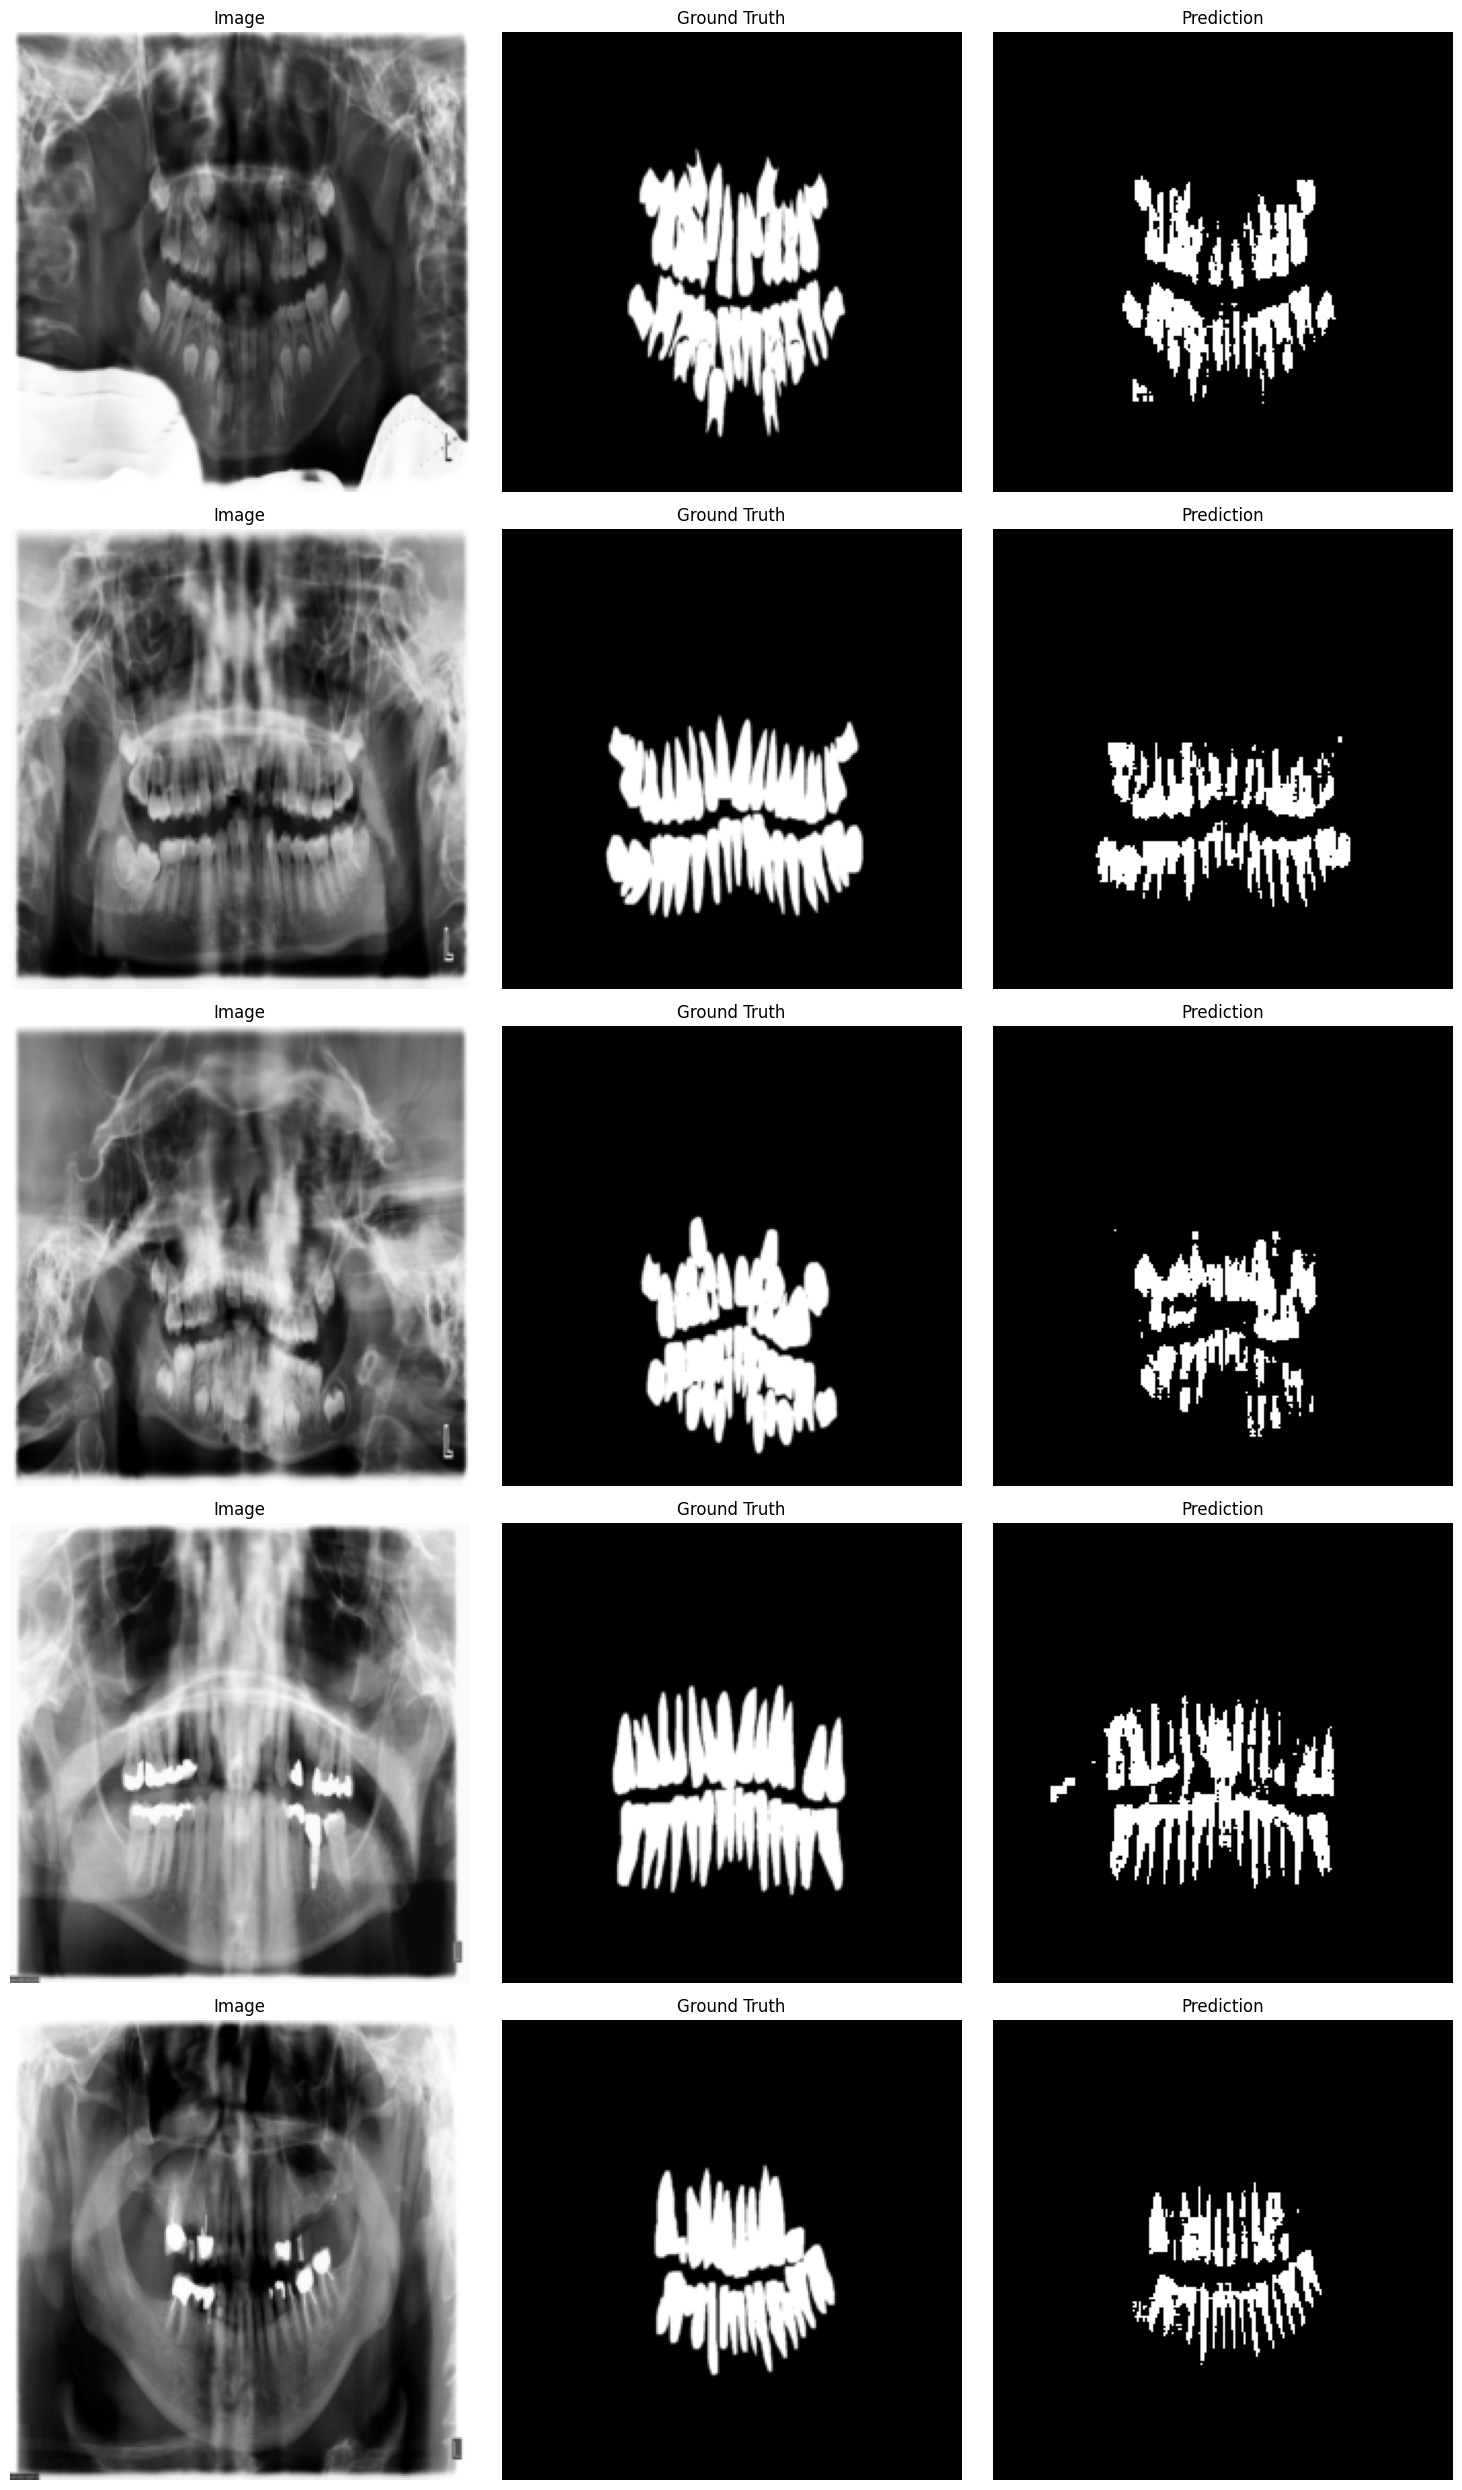

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

def calculate_iou(preds, targets, num_classes):
    iou_list = []
    for cls in range(num_classes):
        pred_inds = preds == cls
        target_inds = targets == cls
        intersection = np.logical_and(pred_inds, target_inds).sum()
        union = np.logical_or(pred_inds, target_inds).sum()
        if union == 0:
            iou_list.append(float('nan'))  # Handle the case where there's no ground truth for a class
        else:
            iou_list.append(intersection / union)
    return iou_list

def evaluate_model(model, test_loader, num_classes):
    model.eval()
    predictions = []
    flat_predictions = []
    flat_labels = []

    with torch.no_grad():
        for images, masks in test_loader:
            images = images.cuda()
            masks = masks.squeeze(1).long().cuda()

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            flat_predictions.extend(predicted.cpu().numpy().flatten())
            flat_labels.extend(masks.cpu().numpy().flatten())

    # Convert lists to numpy arrays
    flat_predictions = np.array(flat_predictions)
    flat_labels = np.array(flat_labels)

    # Calculate metrics
    accuracy = accuracy_score(flat_labels, flat_predictions)
    precision = precision_score(flat_labels, flat_predictions, average='binary', zero_division=1)
    recall = recall_score(flat_labels, flat_predictions, average='binary', zero_division=1)
    f1 = f1_score(flat_labels, flat_predictions, average='binary')

    iou = calculate_iou(flat_predictions, flat_labels, num_classes)
    dice_score = 2 * np.array(iou) / (np.array(iou) + 1)  # Dice score approximation

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'IoU per class: {iou}')
    print(f'Dice Score per class: {dice_score}')

    return predictions

def visualize_results(dataset, predictions, num_samples=5):
    """Visualize a few samples from the dataset along with ground truth and predictions"""
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples * 5))

    for i in range(num_samples):
        # Get sample data from dataset
        img, mask = dataset[i]
        img = img.permute(1, 2, 0).numpy()  # Convert from CxHxW to HxWxC
        mask = mask.squeeze().numpy()

        # Get predictions for the corresponding index
        pred = np.array(predictions[i].reshape(mask.shape))  # Reshape prediction to match mask shape

        # Ensure all data is properly formatted
        img = np.clip(img, 0, 1)  # Clip values to be in the [0, 1] range for visualization

        # Plot image, ground truth, and prediction
        axes[i, 0].imshow(img)
        axes[i, 0].set_title("Image")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title("Ground Truth")
        axes[i, 1].axis('off')

        axes[i, 2].imshow(pred, cmap='gray')
        axes[i, 2].set_title("Prediction")
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming your dataset, test_loader, and model are defined
num_classes = 2  # Update this based on your specific number of classes
predictions = evaluate_model(model, test_loader, num_classes)
visualize_results(test_loader.dataset, predictions)
